In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "../src")

We finally have a calibration box on a table, let's take a look at it.

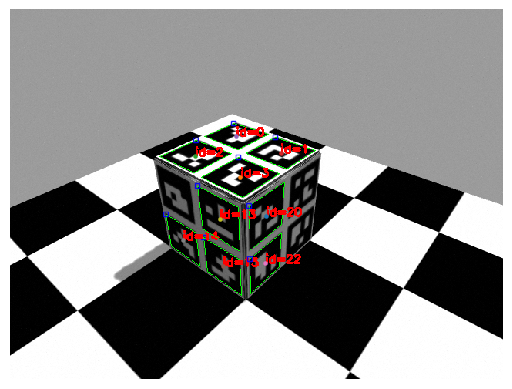

In [47]:
import cv2 as cv
import matplotlib.pyplot as plt
import tempfile
from pathlib import Path
import numpy as np

from camera import (
    move_camera_pos,
    get_camera_image_rgb,
    get_camera_image_depth,
    draw_aruco_grid,
    extract_aruco_tags,
    draw_aruco_tags,
)
import rospy

rospy.init_node("camera_test")
move_camera_pos(-0.4, -0.4, 1, pitch=0.6, yaw=0.7)
rgb = get_camera_image_rgb()
frame_markers, corners, ids = extract_aruco_tags(rgb)
draw_aruco_tags(frame_markers, corners, ids)
plt.show()

This is a photogenic angle, so let's keep that.

## mapping sides to faces

In generally, I want to get a sense of which sides map to which faces.
Then, we can take one of the faces and get the relative distances of each of the centers.

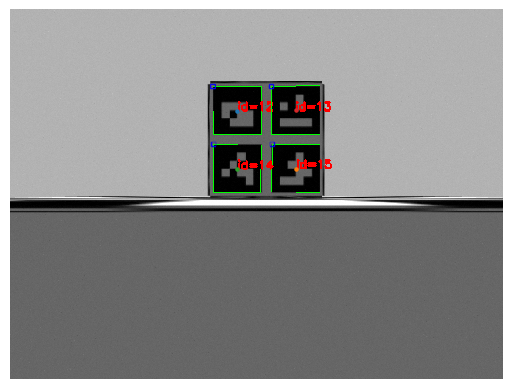

[12, 15, 14, 13]
[3 3 3 3]


In [48]:
def plot_and_list(*args, **kwargs):
    move_camera_pos(*args, **kwargs)
    rgb = get_camera_image_rgb()
    frame_markers, corners, ids = extract_aruco_tags(rgb)
    draw_aruco_tags(frame_markers, corners, ids)
    plt.show()
    x = ids.reshape(-1)
    print(x.tolist())
    print(x // 4)


plot_and_list(-0.75, 0, 0.5)

Above, we're looking at the "front" of the box, which corresponds to face 3.

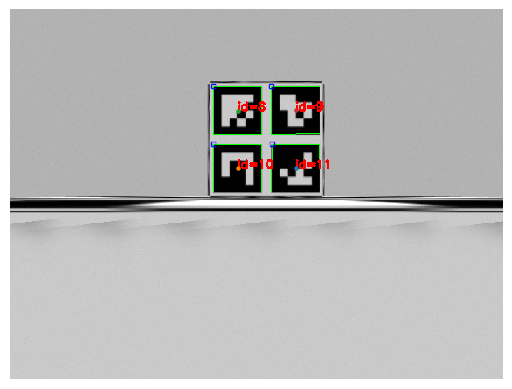

[11, 10, 8, 9]
[2 2 2 2]


In [57]:
plot_and_list(0.75, 0, 0.5, yaw=np.pi)

Above is face 2, which is the "back" side of the box.

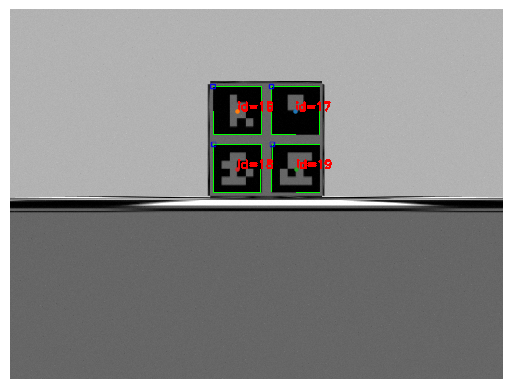

[17, 16, 19, 18]
[4 4 4 4]


In [148]:
plot_and_list(0, 0.75, 0.5, yaw=np.pi / 2 * 3)

Above is face 4, which is the "left" side of the box.
We can imagine going clockwise from the front.

This means that the right side of the box will be face 5, below.

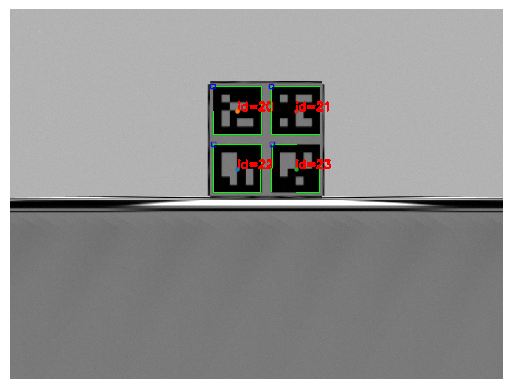

[22, 20, 23, 21]
[5 5 5 5]


In [147]:
plot_and_list(0, -0.75, 0.5, yaw=np.pi / 2)

Finally, we take a look at the top of the box,, which should be face 0.

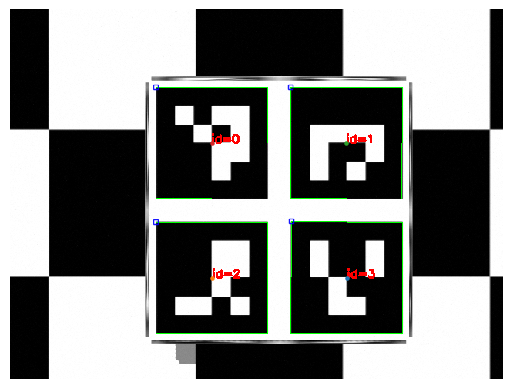

[3, 2, 1, 0]
[0 0 0 0]


In [160]:
plot_and_list(0, 0, 1, pitch=np.pi / 2)

## face measurements

Where are the centers of each of the boxes?
Lets draw some red lines in the right places.
We'll do this in one dimension and assume that symmetry holds.

center at (97.5, 97.5)
center at (97.5, 307.5)
center at (307.5, 97.5)
center at (307.5, 307.5)


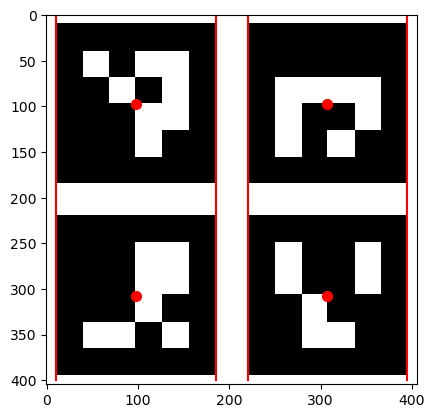

In [96]:
img = plt.imread("../models/calibration_box/materials/textures/aruco_0.png")
plt.imshow(img)

# draw some red lines, from 0 to 400
b = 10
w = 175
for x in [b, b + w, b + w + 35, b + w + 35 + w]:
    plt.plot([x, x], [0, 400], "r")

# now lets also draw the centers of the aruco markers using border b and width w
for x in [b + w / 2, b + w + 35 + w / 2]:
    for y in [b + w / 2, b + w + 35 + w / 2]:
        plt.scatter([x], [y], s=50, c="red")
        print(f"center at ({x}, {y})")

plt.show()

## mapping ids to world coordinates

Now that we know which face corresponds to which face, we can map the ids to world coordinates.

In [166]:
b = 10
w = 175
total = 400
rel_coords = []
for x in [b + w / 2, b + w + 35 + w / 2]:
    for y in [b + w / 2, b + w + 35 + w / 2]:
        rel_coords.append((x / total, y / total))
rel_coords = np.array(rel_coords)

# let's translate the coordinates so they center around 0
rel_coords -= 0.5

# now scale these so they are in the range [-0.1, 0.1] corresponding to a unit
# cube scaled by 1/5
side_length = 0.1
rel_coords *= side_length

# now we have to map these to each of the sides
ones = np.ones((4, 1))
zeros = np.zeros((4, 1))

# add a third dimension that's all 0.1
top = np.hstack([rel_coords, ones * side_length])
print("top")
print(top)

# the bottom is the same as the top, but mirrored
# NOTE: honestly, not sure about this one, but it doesn't particularly matter
# because we're not using the bottom side
bottom = np.hstack([rel_coords[[1, 0, 3, 2]], zeros])
print("bottom")
print(bottom)


# the front side moves the x position to -0.1, which means that our relative coordinates
# are now the y and z coordinates.

y_z_off = np.hstack([zeros, ones * 0.5 * side_length])

front = np.hstack([ones * -side_length, rel_coords[[1, 3, 0, 2]] + y_z_off])
print("front")
print(front)

# the back side is the same as the front side, but mirrored
back = np.hstack([ones * side_length, rel_coords[[3, 1, 2, 0]] + y_z_off])
print("back")
print(back)

# the left side is the same as the back side, but rotated 90 degrees
# this means we can likely just transpose dimensions of the front side
left = front[:, [1, 0, 2]]
print("left")
print(left)

# the right side is the same as the left side, but mirrored
right = back[:, [1, 0, 2]]
print("right")
print(right)

# now we can combine all of these into a single array
sides = np.vstack([top, bottom, front, back, left, right])
sides

top
[[-0.025625 -0.025625  0.1     ]
 [-0.025625  0.026875  0.1     ]
 [ 0.026875 -0.025625  0.1     ]
 [ 0.026875  0.026875  0.1     ]]
bottom
[[-0.025625  0.026875  0.      ]
 [-0.025625 -0.025625  0.      ]
 [ 0.026875  0.026875  0.      ]
 [ 0.026875 -0.025625  0.      ]]
front
[[-0.1      -0.025625  0.076875]
 [-0.1       0.026875  0.076875]
 [-0.1      -0.025625  0.024375]
 [-0.1       0.026875  0.024375]]
back
[[ 0.1       0.026875  0.076875]
 [ 0.1      -0.025625  0.076875]
 [ 0.1       0.026875  0.024375]
 [ 0.1      -0.025625  0.024375]]
left
[[-0.025625 -0.1       0.076875]
 [ 0.026875 -0.1       0.076875]
 [-0.025625 -0.1       0.024375]
 [ 0.026875 -0.1       0.024375]]
right
[[ 0.026875  0.1       0.076875]
 [-0.025625  0.1       0.076875]
 [ 0.026875  0.1       0.024375]
 [-0.025625  0.1       0.024375]]


array([[-0.025625, -0.025625,  0.1     ],
       [-0.025625,  0.026875,  0.1     ],
       [ 0.026875, -0.025625,  0.1     ],
       [ 0.026875,  0.026875,  0.1     ],
       [-0.025625,  0.026875,  0.      ],
       [-0.025625, -0.025625,  0.      ],
       [ 0.026875,  0.026875,  0.      ],
       [ 0.026875, -0.025625,  0.      ],
       [-0.1     , -0.025625,  0.076875],
       [-0.1     ,  0.026875,  0.076875],
       [-0.1     , -0.025625,  0.024375],
       [-0.1     ,  0.026875,  0.024375],
       [ 0.1     ,  0.026875,  0.076875],
       [ 0.1     , -0.025625,  0.076875],
       [ 0.1     ,  0.026875,  0.024375],
       [ 0.1     , -0.025625,  0.024375],
       [-0.025625, -0.1     ,  0.076875],
       [ 0.026875, -0.1     ,  0.076875],
       [-0.025625, -0.1     ,  0.024375],
       [ 0.026875, -0.1     ,  0.024375],
       [ 0.026875,  0.1     ,  0.076875],
       [-0.025625,  0.1     ,  0.076875],
       [ 0.026875,  0.1     ,  0.024375],
       [-0.025625,  0.1     ,  0.0